In [16]:
import gym
import numpy as np

In [17]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 1000

In [18]:
class Tilecoder:

    def __init__(self, numTilings, tilesPerTiling):
        # Set max value for normalization of inputs
        self.maxNormal = 1
        self.maxVal = env.observation_space.high
        self.minVal = env.observation_space.low
        self.numTilings = numTilings
        self.tilesPerTiling = tilesPerTiling
        self.dim = len(self.maxVal)
        self.numTiles = (self.tilesPerTiling**self.dim) * self.numTilings
        self.actions = env.action_space.n
        self.n = self.numTiles * self.actions
        self.tileSize = np.divide(np.ones(self.dim)*self.maxNormal, self.tilesPerTiling-1)

    def getFeatures(self, variables):
        # Ensures range is always between 0 and self.maxValue
        values = np.zeros(self.dim)
        for i in range(len(env.observation_space.shape)+1):
            values[i] = self.maxNormal * ((variables[i] - self.minVal[i])/(self.maxVal[i]-self.minVal[i]))
        tileIndices = np.zeros(self.numTilings)
        matrix = np.zeros([self.numTilings,self.dim])
        for i in range(self.numTilings):
            for i2 in range(self.dim):
                matrix[i,i2] = int(values[i2] / self.tileSize[i2] + i / self.numTilings)
        for i in range(1,self.dim):
            matrix[:,i] *= self.tilesPerTiling**i
        for i in range(self.numTilings):
            tileIndices[i] = (i * (self.tilesPerTiling**self.dim) + sum(matrix[i,:])) 
        return tileIndices

    def oneHotVector(self, features, action):
        oneHot = np.zeros(self.n)
        for i in features:
            index = int(i + (self.numTiles*action))
            oneHot[index] = 1
        return oneHot

    def getVal(self, theta, features, action):
        val = 0 
        for i in features:
            index = int(i + (self.numTiles*action))
            val += theta[index]
        return val

    def getQ(self, features, theta):
        Q = np.zeros(self.actions)
        for i in range(self.actions):
            Q[i] = tile.getVal(theta, features, i)
        return Q

In [19]:
    tile = Tilecoder(7,14)
    theta = np.random.uniform(-0.001, 0, size=(tile.n))
    alpha = (.1/ tile.numTilings)*3.2
    gamma = 1
    numEpisodes = 100000
    rewardTracker = []
    episodeSum = 0
    counter = 0 
    eps = 0.5
    
    for episodeNum in range(1,numEpisodes+1):
        G = 0
        state = env.reset()
        while True:
            #env.render()
            F = tile.getFeatures(state)
            Q = tile.getQ(F, theta)
            action = np.argmax(Q) if np.random.random() > eps \
                                    else np.random.choice([0,1,2])
            state2, reward, done, info = env.step(action)
            G += reward
            delta = reward - Q[action]
            if done == True:
                theta += np.multiply((alpha*delta), tile.oneHotVector(F,action))
                episodeSum += G
                rewardTracker.append(G)
                if episodeNum %100 == 0:
                    print('Average reward = {}'.format(episodeSum / 100))
                    episodeSum = 0
                break
            Q = tile.getQ(tile.getFeatures(state2), theta)
            delta += gamma*np.max(Q)
            theta += np.multiply((alpha*delta), tile.oneHotVector(F,action))
            state = state2

        if episodeNum > 100:
            if sum(rewardTracker[episodeNum-100:episodeNum])/100 >= -110:
                print('Solve in {} Episodes'.format(episodeNum))
                break
        eps = eps-4/numEpisodes if eps > 0.01 else 0.01

Average reward = -422.67
Average reward = -256.63
Average reward = -224.22
Average reward = -228.86
Average reward = -234.97
Average reward = -234.49
Average reward = -238.68
Average reward = -239.72
Average reward = -249.2
Average reward = -236.52
Average reward = -242.09
Average reward = -249.53
Average reward = -248.63
Average reward = -255.13
Average reward = -249.68
Average reward = -243.34
Average reward = -242.36
Average reward = -234.49
Average reward = -245.98
Average reward = -237.87
Average reward = -240.19
Average reward = -248.29
Average reward = -231.25
Average reward = -241.02
Average reward = -227.29
Average reward = -235.36
Average reward = -231.61
Average reward = -219.22
Average reward = -234.51
Average reward = -220.31
Average reward = -228.12
Average reward = -225.31
Average reward = -230.27
Average reward = -223.99
Average reward = -233.37
Average reward = -218.58
Average reward = -213.09
Average reward = -220.54
Average reward = -222.07
Average reward = -218.43
A

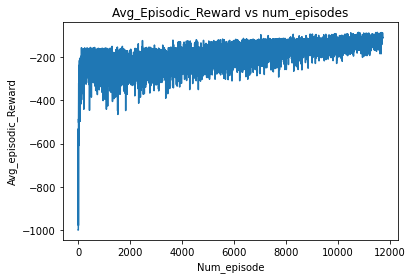

In [20]:
import matplotlib.pyplot as plt


plt.plot(rewardTracker)
plt.title("Avg_Episodic_Reward vs num_episodes")
plt.xlabel("Num_episode")
plt.ylabel("Avg_episodic_Reward")
plt.savefig('tile_coding_q_mc')